# Queun类

In [1]:
import numpy as np
from queue import Queue
a=np.array([1,2])
b=np.array([5,6])
c=np.array([7,8])
q=Queue(2)
q.put(a)
q.put(b)
if q.full():
    q.get()
    q.put(c)
    
print(q.full())
print(q.empty())
print(q.get())
print(q.get())


True
False
[5 6]
[7 8]


# Input_data类

In [85]:
import numpy as np
import random
from queue import Queue

class Input_data:
    def __init__(self,capacity=10000,minibatch_size=100):
        self.capacity=capacity
        self.minibatch_size=minibatch_size
        self.q=Queue(capacity)  
     
    #添加array()形式的transition到队列，按list存储：[array(),array()...]
    #transition: (s,a,r,s')
    def add_transition(self,*transition):
        if self.q.full():
            self.q.get_nowait()
            self.q.put(transition[0])
        else:
            self.q.put(transition[0])
     
    # 按array随机返回minibatch：[[],[]...]
    def next_train_batch(self):
        return np.array(random.sample(self.q.queue,self.minibatch_size))
    
    # 返回队列大小
    def size(self):
        return self.q.qsize()
    
    #测试用
    #移除一个数据
    def remove(self):
        return self.q.get_nowait()
    
    #返回队列所有数据
    def showQueue(self):
        return self.q.queue
        

In [2]:
# ------------------------test----------------------------
d=np.array([3,4])
e=np.array([5,6])
f=np.array([7,8])
input=Input_data(3,2)
input.add_transition(d)
input.add_transition(e)
input.add_transition(f)
print(input.showQueue())
print(input.next_train_batch())
# print(input.q.get_nowait()[0])
# print(input.q.get_nowait()[0])
# print(input.q.empty())

deque([array([3, 4]), array([5, 6]), array([7, 8])])
[[5 6]
 [3 4]]


# DQN

<IPython.core.display.Javascript object>


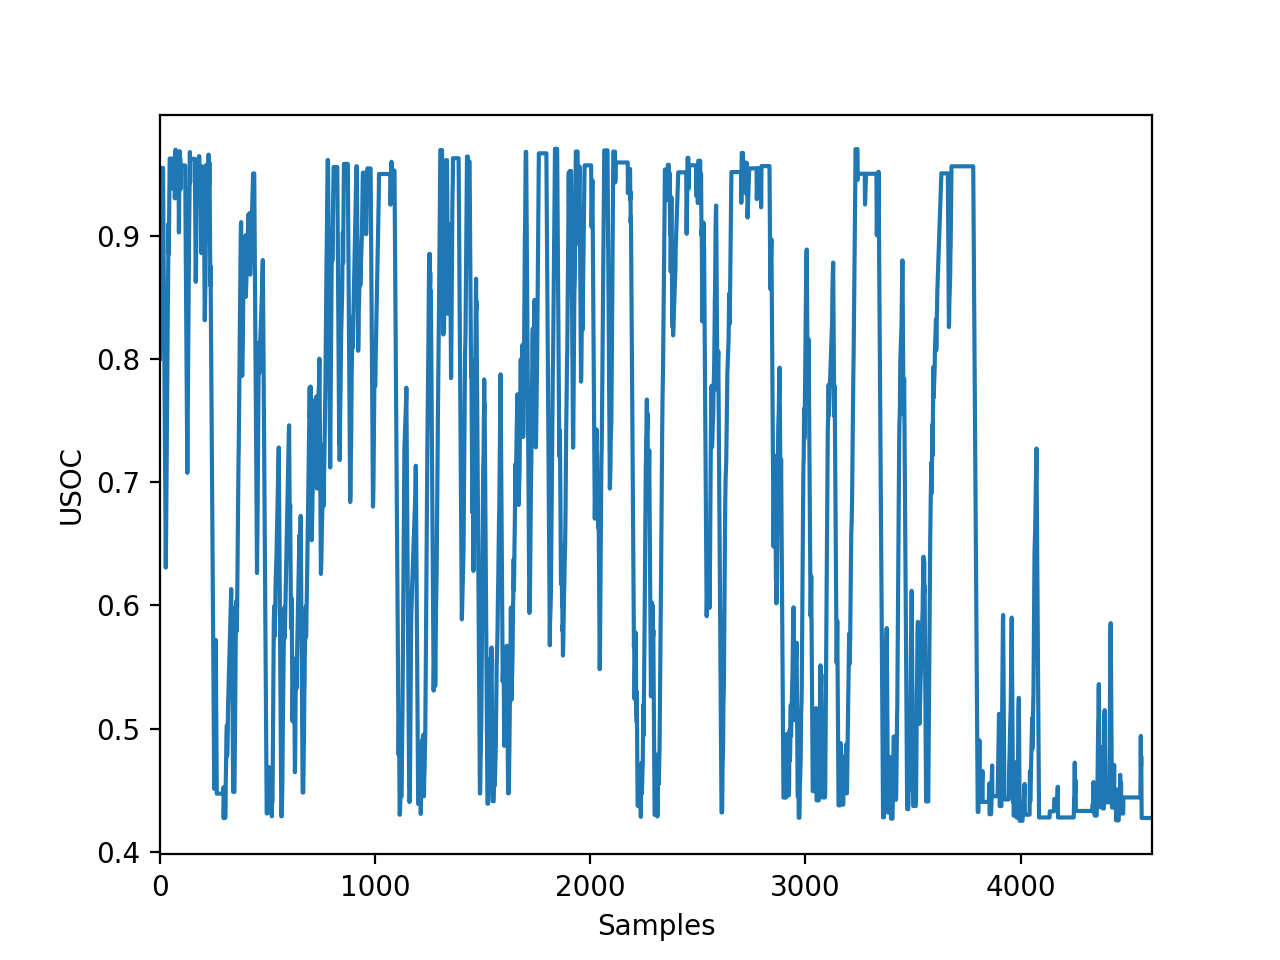

<IPython.core.display.Javascript object>


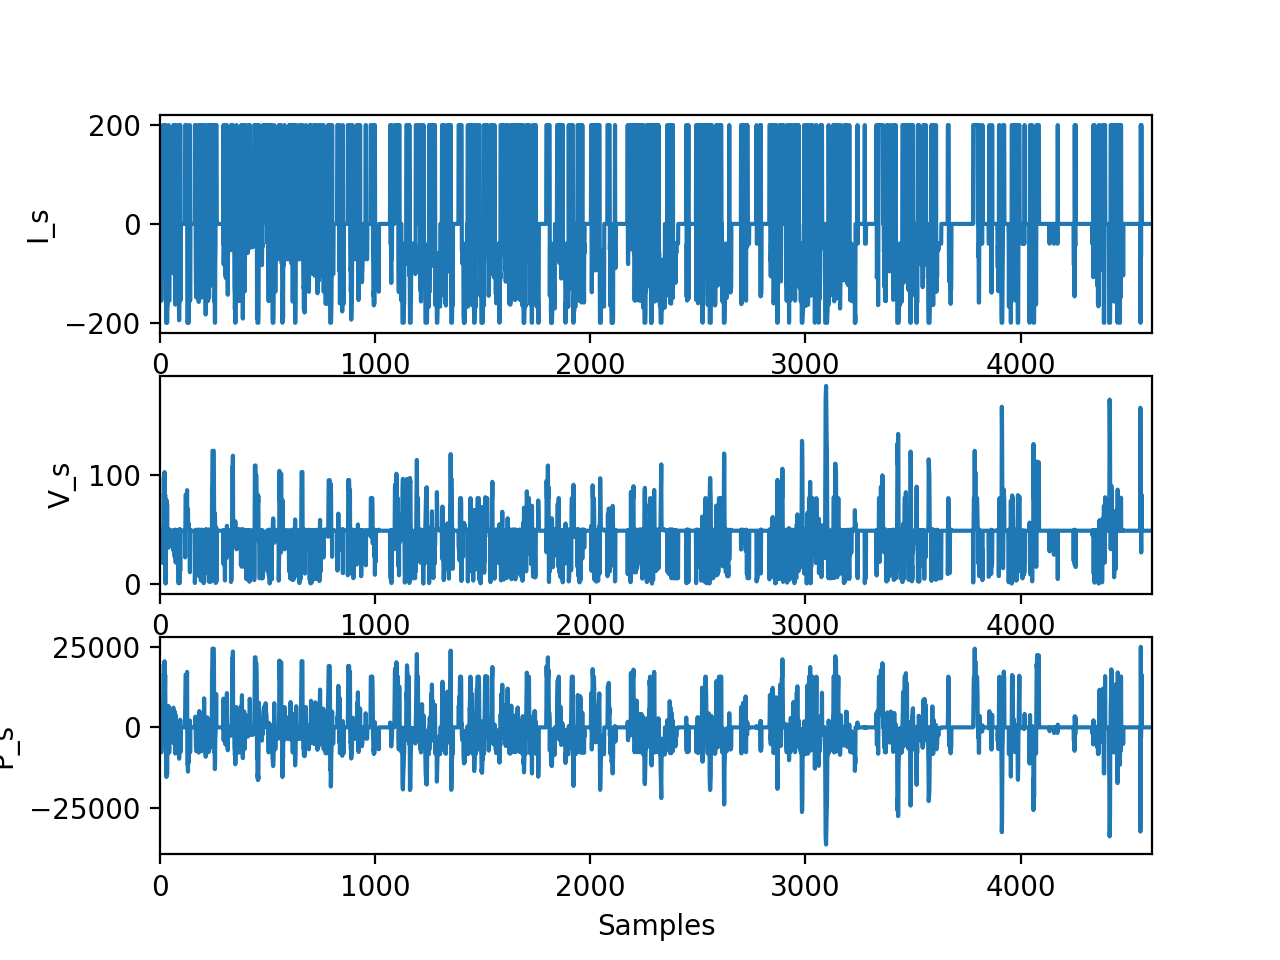

In [86]:
import tensorflow as tf
import random
import scipy.io as sio
import matplotlib.pyplot as plt
from IPython import display

# define graph and session
tf.reset_default_graph()
g2=tf.Graph()
sess=tf.Session()
sess2=tf.Session(graph=g2)

# import training data
data=sio.loadmat('trainpower2.mat') 
# one-dimension numpy array
p_dem=data['trainpower'][:,0]

# initialization
M=1 #maximum iteration
T=len(p_dem)-1   #episode length,减1,最后一个数据作为终止标志
p_dem[T]=1e+8 #epidode end mark
greedy_factor=0.9 #greedy factor
gamma=0.9 #discount factor
hidden_num=10 #number of hidden neuron
action_num=31 #number of output neuron/action
dispersion=300 #dispersion of action space
pool_size=4000  #size of experience pool
batch=200 #training batch
lr=0.001 #learning rate
C=100 #every C step reset Q'=Q
N=0 #learning step counter
pool=Input_data(pool_size,batch) #define pool size and train batch

U_b=64 #open-loop voltage of li-battery
U_s=48.6 #maximum voltage of super-capacitor
R_b=0.08 #internal resistance of li-battery
R_s=0.0063 #internal resistance of super-capacitor
C_b=2000 # battery capacity
C_s=8019 #capacitor capacity
bsoc_ini=0.8 #initial battery soc
usoc_ini=0.8 #initial capacitor soc



def trainNet(state,transition,q_value_):
    
    w1=tf.get_variable("w1",[2,hidden_num],initializer=tf.random_normal_initializer(mean=0,stddev=0.1))
    b1=tf.get_variable("b1",[hidden_num],initializer=tf.constant_initializer(0.1))
    w2=tf.get_variable("w2",[hidden_num,action_num],initializer=tf.random_normal_initializer(mean=0,stddev=0.1))
    b2=tf.get_variable("b2",[action_num],initializer=tf.constant_initializer(0.1))
    
    #获取单样本state对应的action_index，存储在pool中
    hidden=tf.nn.relu(tf.matmul(state,w1)+b1)
    y=tf.matmul(hidden,w2)+b2
    action_index=tf.argmax(tf.squeeze(y))
    
    #获取批样本action_index对应的q_value，用于训练参数
    hidden_=tf.nn.relu(tf.matmul(transition[:,0:2],w1)+b1)
    y_=tf.matmul(hidden_,w2)+b2
    q_value=tf.reduce_max(tf.multiply(tf.one_hot(tf.cast(transition[:,2],tf.uint8),action_num),y_),reduction_indices=1)
    
    #计算loss function, 用于训练参数
    loss=tf.reduce_mean(tf.square(q_value-(transition[:,3]+gamma*q_value_)))
    train_step=tf.train.AdamOptimizer(lr).minimize(loss)
    return [action_index,w1,b1,w2,b2,train_step,loss]

def targetNet(state,w1,b1,w2,b2):
    
    hidden=tf.nn.relu(tf.matmul(state,w1)+b1)
    y=tf.matmul(hidden,w2)+b2
    q_value_=tf.reduce_max(y,reduction_indices=1)
    
    #s_end的q_value_置0
    q_value_=tf.multiply(tf.cast(tf.cast(state[:,1]+1,bool),tf.float32),q_value_)
    return q_value_
    

def env(s,a,p_dem_,bsoc_):
    
    p_dem=s[0]
    usoc_=s[1]
    p_b=a*dispersion
    p_s=p_dem-p_b
    
    #battery soc update
    i_b=(U_b+(U_b**2-4*p_b*R_b)**0.5)/(2*R_b) if p_b>0 else 0
    i_b=100 if i_b>100 else i_b
    u_b=p_b/i_b if i_b!=0 else U_b
    bsoc_=bsoc_-i_b/(3600*C_b)
    
    #capacitor soc update
    p_s=0 if (usoc_>0.95 and p_s<=0) or (usoc_<0.45 and p_s>0) else p_s
    
    if p_s>0:
        i_s=(U_s+(U_s**2-4*p_s*R_s)**0.5)/(2*R_s)
        i_s=200 if i_s>200 else i_s
        i_s=40 if i_s<40 else i_s
    elif p_s<0:
        i_s=(U_s-(U_s**2-4*p_s*R_s)**0.5)/(2*R_s)
        i_s=-200 if i_s<-200 else i_s
        i_s=-40 if i_s>-40 else i_s
    else:
        i_s=0
        
    u_s=p_s/i_s if i_s!=0 else U_s
    usoc_=usoc_-i_s/C_s
    
    #s_end=[p_dem[T],-1]
    s_=[p_dem_,-1] if p_dem_==1e+8 else [p_dem_,usoc_]
    reward=-1000 if usoc_<0.45 or usoc_>0.95 else 0
    return [reward,s_,bsoc_,i_s,u_s,p_s]

    
with tf.variable_scope("train_net",reuse=tf.AUTO_REUSE) as scope:
    state=tf.placeholder("float",shape=[1,2])
    transition=tf.placeholder("float",shape=[None,6])
    target=tf.placeholder("float",shape=[None])
    var=trainNet(state,transition,target)
    
with g2.as_default():
    state_=tf.placeholder("float",shape=[None,2])
    w1=tf.placeholder("float",shape=[2,hidden_num])
    b1=tf.placeholder("float",shape=[hidden_num])
    w2=tf.placeholder("float",shape=[hidden_num,action_num])
    b2=tf.placeholder("float",shape=[action_num])
    target_=targetNet(state_,w1,b1,w2,b2)
    
sess.run(tf.global_variables_initializer())

for i in range(M):
    
    s=[p_dem[0],usoc_ini]  #initial state
    bsoc_=bsoc_ini
    usoc=[]
    I_s=[]
    V_s=[]
    P_s=[]
    
    for t in range(T):
        
        if random.random()>greedy_factor:
            action=random.randrange(0,action_num,1)
#             print('action from ramdom selection:{}\n'.format(action))
        else:
            action=sess.run(var[0],feed_dict={state:[s]})
#             print('action from maximum selection:{}\n'.format(action))
        
        reward,s_,bsoc_,i_s,u_s,p_s=env(s,action,p_dem[t+1],bsoc_)
        pool.add_transition([s[0],s[1],action,reward,s_[0],s_[1]]) 
        usoc.append(s[1])
        I_s.append(i_s)
        V_s.append(u_s)
        P_s.append(p_s)
        
        s=s_
        
        if pool.size()>=batch:
            
            trainBatch=pool.next_train_batch()

            if N%C==0:
                w1_=sess.run(var[1])
                b1_=sess.run(var[2])
                w2_=sess.run(var[3])
                b2_=sess.run(var[4])
            
            sess.run(var[5],feed_dict={transition:trainBatch,
                                     target:sess2.run(target_,feed_dict={state_:trainBatch[:,4:6],
                                                                         w1:w1_,
                                                                         b1:b1_,
                                                                         w2:w2_,
                                                                         b2:b2_})})
                                                                        
            
        
            N=N+1
#             print('learning step:{}\n'.format(N))
            

#     print('usoc:{}'.format(usoc[0:100]))
#     print('I_s:{}'.format(I_s[0:100]))
#     print('V_s:{}'.format(V_s[0:100]))
#     print('P_s:{}'.format(P_s[0:100]))
#     print(i)
    %matplotlib notebook
    plt.figure(1)
    plt.plot(range(len(usoc)),usoc)
    plt.xlabel('Samples')
    plt.ylabel('USOC')
    plt.xlim(0,len(usoc))
    plt.show()
    plt.figure(2)
    ax1=plt.subplot(311)
    plt.plot(range(len(I_s)),I_s)
    plt.xlabel('Samples')
    plt.ylabel('I_s')
    plt.xlim(0,len(I_s))
    ax2=plt.subplot(312)
    plt.plot(range(len(V_s)),V_s)
    plt.xlabel('Samples')
    plt.ylabel('V_s')
    plt.xlim(0,len(V_s))
    ax3=plt.subplot(313)
    plt.plot(range(len(P_s)),P_s)
    plt.xlabel('Samples')
    plt.ylabel('P_s')
    plt.xlim(0,len(P_s))
    plt.show()
    display.clear_output(wait=True)
    
# summary_writer = tf.summary.FileWriter("/Users/xieliang/tensorboard/log", sess2.graph)

# print(sess2.run(target_,feed_dict={state_:[[6000,-1],[6000,0.9],[5000,-1]],
#                                     w1:sess.run(var[1]),
#                                     b1:sess.run(var[2]),
#                                     w2:sess.run(var[3]),
#                                     b2:sess.run(var[4])}))

# print('\nerror is: \n {}\n'.format(sess.run(var[5],feed_dict={transition:trainBatch,
#                                                                                      target:sess2.run(target_,feed_dict={state_:trainBatch[:,4:6],
#                                                                                                                         w1:sess.run(var[1]),
#                                                                                                                         b1:sess.run(var[2]),
#                                                                                                                         w2:sess.run(var[3]),
#                                                                                                                         b2:sess.run(var[4])})})))

# DQN+MLP

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

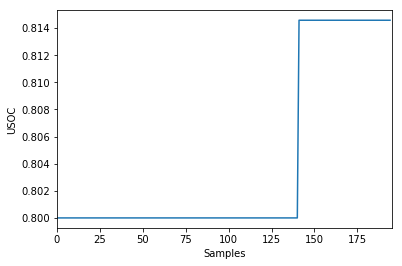

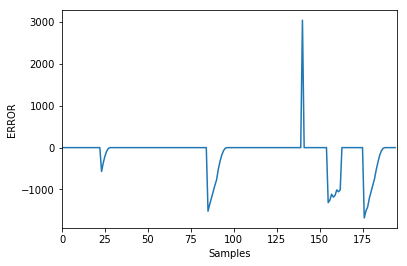

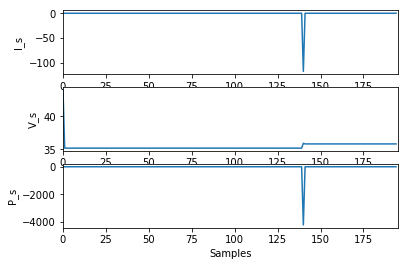

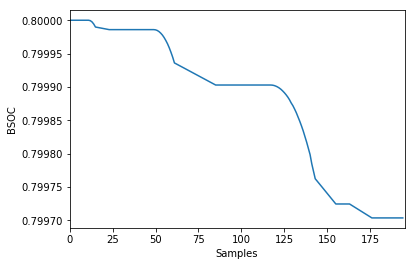

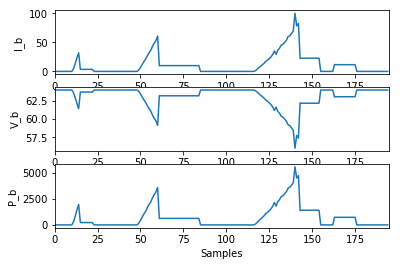

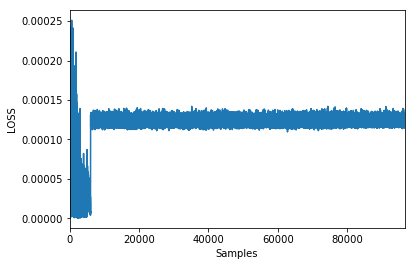

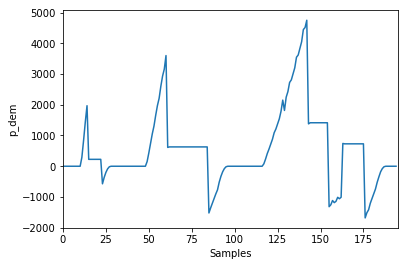

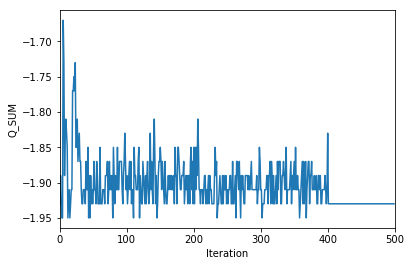

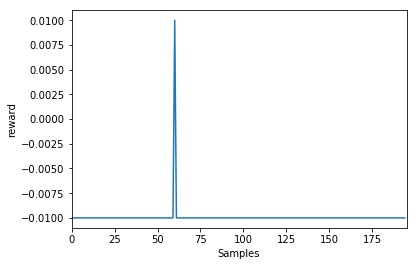

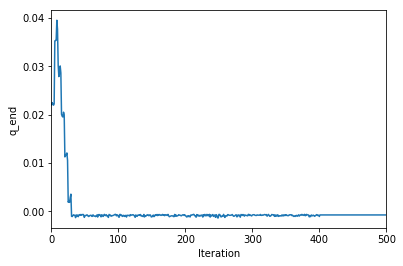

In [1]:
import tensorflow as tf
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
from pandas import read_csv


tf.reset_default_graph()
tf.set_random_seed(1)
np.random.seed(1)

# import training data
ECE_T = np.genfromtxt('../data/ECE_T.txt', skip_header=1, delimiter=' ', dtype=None)
ECE_S = np.genfromtxt('../data/ECE_S.txt', skip_header=1, delimiter=' ', dtype=None)
ECE_P=ECE_T*ECE_S/9.549
# yy=np.genfromtxt('../data/ECE_P.txt', skip_header=1, delimiter=' ', dtype=None)*1000
# print(ECE_P.shape)=1950

EUDC_T = np.genfromtxt('../data/EUDC_T.txt', skip_header=1, delimiter=' ', dtype=None)
EUDC_S = np.genfromtxt('../data/EUDC_S.txt', skip_header=1, delimiter=' ', dtype=None)
EUDC_P=EUDC_T*EUDC_S/9.549
# print(EUDC_P.shape)=10868

HWFET_T = np.genfromtxt('../data/HWFET_T.txt', skip_header=1, delimiter=' ', dtype=None)
HWFET_S = np.genfromtxt('../data/HWFET_S.txt', skip_header=1, delimiter=' ', dtype=None)
HWFET_P=HWFET_T*HWFET_S/9.549
# print(HWFET_P.shape)=7659

# data=sio.loadmat('trainpower2.mat')
# data=read_csv(open('UDDS.csv'),engine='python')
# one-dimension numpy array
# data1=data.values.flatten()
# 采样精度0.1s，按每10位取平均数
data2=np.mean(ECE_P[:int(np.size(ECE_P)/10)*10].reshape(-1,10),axis=1)
# 归一化
Max=data2.max()
Min=data2.min()
p_dem=(data2-Min)/(Max-Min)


# # hyper parameters of HWFET
# M=100                      #maximum iteration
# EPSILON=0.9             #greedy factor
# GAMMA=0.99               #discount factor
# N_HIDDEN=30             #number of hidden neuron
# N_STATES=2              #number of states
# N_ACTIONS=21            #number of output neuron/action
# D=300                   #dispersion of action space
# BATCH=100               #training batch
# LR=0.001                #learning rate
# DELTA_T=1               #sampling time step
# C=200                   #every C step update target net
# POOL_SIZE=3000          #size of experience pool
## reward-=-0.01

# hyper parameters of ECE
M=500                     #maximum iteration
EPSILON=0.9             #greedy factor
GAMMA=0.99               #discount factor
N_HIDDEN=15             #number of hidden neuron
N_STATES=2              #number of states
N_ACTIONS=20            #number of output neuron/action
D=600                   #dispersion of action space
BATCH=30               #training batch
LR=0.001                #learning rate
DELTA_T=1               #sampling time step
C=1000                   #every C step update target net
POOL_SIZE=1000          #size of experience pool
# reward-=-0.01,i>M-100


# # hyper parameters of EUDC
# M=180                     #maximum iteration
# EPSILON=0.9             #greedy factor
# GAMMA=0.9               #discount factor
# N_HIDDEN=15             #number of hidden neuron
# N_STATES=2              #number of states
# N_ACTIONS=40            #number of output neuron/action
# D=300                   #dispersion of action space
# BATCH=150               #training batch
# LR=0.001                #learning rate
# DELTA_T=1               #sampling time step
# C=1000                   #every C step update target net
# POOL_SIZE=5000          #size of experience pool
# # reward-=-0.03,i>M-20

# initialization
U_b=64        #open-loop voltage of li-battery
U_max=44        #maximum voltage of super-capacitor
U_s=44        #ideal voltage of super-capacitor
R_b=0.08      #internal resistance of li-battery
R_s=0.0063    #internal resistance of super-capacitor
Q_b=2000      #battery capacity
Q_s=8019      #capacitor capacity

LOSS=[]
Q_SUM=[]
Q_END=[]
LEARNING_COUNTER=0      #for target net updating
COUNTER=0               # for experience updating   
T=p_dem.size            #episode length
POOL=np.zeros((POOL_SIZE,N_STATES*2+2)) 

# define graph
tf_s=tf.placeholder(tf.float32,[None,N_STATES],name='tf_s')
tf_a=tf.placeholder(tf.int32,[None,],name='tf_a')
tf_r=tf.placeholder(tf.float32,[None,],name='tf_r')
tf_s_=tf.placeholder(tf.float32,[None,N_STATES],name='tf_s_')

with tf.variable_scope('train_net'):
    h=tf.layers.dense(tf_s,N_HIDDEN,tf.nn.relu,kernel_initializer=tf.random_normal_initializer(0,0.1))
    q=tf.layers.dense(h,N_ACTIONS,kernel_initializer=tf.random_normal_initializer(0,0.1))
    
with tf.variable_scope('target_net'):
    h_=tf.layers.dense(tf_s_,N_HIDDEN,tf.nn.relu,trainable=False)
    q_=tf.layers.dense(h_,N_ACTIONS,trainable=False)

#s_end=[-1,-1]对应的q_需要置0
q_target=tf_r+GAMMA*tf.multiply(tf.reduce_max(q_,axis=1),tf.cast(tf.cast(tf_s_[:,1]+1,bool),tf.float32))
q_wrt_a=tf.reduce_max(tf.multiply(tf.one_hot(tf_a,N_ACTIONS),q),axis=1)
# a_indices = tf.stack([tf.range(tf.shape(tf_a)[0], dtype=tf.int32), tf_a], axis=1)
# q_wrt_a = tf.gather_nd(params=q, indices=a_indices)     # shape=[None, ],[None,1]!=[None,]

loss = tf.reduce_mean(tf.squared_difference(q_target, q_wrt_a))
train_op = tf.train.AdamOptimizer(LR).minimize(loss)

t_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='target_net')
e_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='train_net')
update=[tf.assign(t, e) for t, e in zip(t_params, e_params)]


tf.summary.scalar('W1_mean',tf.reduce_mean(e_params[0]))
tf.summary.scalar('W1_max',tf.reduce_max(e_params[0]))
tf.summary.scalar('W1_min',tf.reduce_min(e_params[0]))
tf.summary.scalar('W1_var',tf.reduce_mean(tf.square(e_params[0]-tf.reduce_mean(e_params[0]))))
tf.summary.scalar('b1_mean',tf.reduce_mean(e_params[1]))
tf.summary.scalar('b1_max',tf.reduce_max(e_params[1]))
tf.summary.scalar('b1_min',tf.reduce_min(e_params[1]))
tf.summary.scalar('b1_var',tf.reduce_mean(tf.square(e_params[1]-tf.reduce_mean(e_params[1]))))
tf.summary.scalar('W2_mean',tf.reduce_mean(e_params[2]))
tf.summary.scalar('W2_max',tf.reduce_max(e_params[2]))
tf.summary.scalar('W2_min',tf.reduce_min(e_params[2]))
tf.summary.scalar('W2_var',tf.reduce_mean(tf.square(e_params[2]-tf.reduce_mean(e_params[2]))))
tf.summary.scalar('b2_mean',tf.reduce_mean(e_params[3]))
tf.summary.scalar('b2_max',tf.reduce_max(e_params[3]))
tf.summary.scalar('b2_min',tf.reduce_min(e_params[3]))
tf.summary.scalar('b2_var',tf.reduce_mean(tf.square(e_params[3]-tf.reduce_mean(e_params[3]))))
tf.summary.histogram('h',h)
tf.summary.histogram('q',q)
tf.summary.histogram('W1',e_params[0])
tf.summary.histogram('b1',e_params[1])
tf.summary.histogram('W2',e_params[2])
tf.summary.histogram('b2',e_params[3])
writer = tf.summary.FileWriter("/Users/xieliang/tensorboard/log")
summaries = tf.summary.merge_all()

sess=tf.Session()
sess.run(tf.global_variables_initializer())
    

def choose_action(s):
    
    s=s[np.newaxis,:]
    
    if np.random.uniform()<=EPSILON:
        q_value=sess.run(q,feed_dict={tf_s:s})
        action_index=np.argmax(q_value)
        Q_max.append(np.max(q_value))
    else:
        action_index=np.random.randint(0,N_ACTIONS)
        
    return action_index


def env(action_index,t):
    
    global usoc,USOC,U_s,bsoc,BSOC,I_s,V_s,P_s,I_b,V_b,P_b,ERROR,REWARD
    
    # power allocation for supercapacitor
    p_s=action_index*D-6000
    
    #capacitor soc update
    p_s=0 if (usoc>0.95 and p_s<=0) or (usoc<0.4 and p_s>0) else p_s
    i_s=(U_s-(U_s**2-4*p_s*R_s)**0.5)/(2*R_s)
    i_s=180 if i_s>180 else i_s
    i_s=-180 if i_s<-180 else i_s
    #i_s=40 if (i_s>0 and i_s<40) else i_s
    #i_s=-40 if (i_s>-40 and i_s<0) else i_s 
    u_s=U_s-i_s*R_s
    p_s=u_s*i_s
    USOC.append(usoc)
    usoc=usoc-i_s*DELTA_T/Q_s
    U_s=usoc*U_max
    
    # power allocation for battery
    p_b=max(p_dem[t]*(Max-Min)+Min-p_s,0)
    
    #battery soc update
    i_b=(U_b-(U_b**2-4*p_b*R_b)**0.5)/(2*R_b)
    i_b=100 if i_b>100 else i_b
    u_b=U_b-i_b*R_b
    p_b=i_b*u_b
    BSOC.append(bsoc)
    bsoc=bsoc-i_b*DELTA_T/(3600*Q_b)

    
    #s_end=[-1,-1]
    s_=np.array([-1,-1]) if t==T-1 else np.array([p_dem[t+1],usoc])
    error=p_dem[t]*(Max-Min)+Min-p_b-p_s
    reward=-0.01 if (usoc<0.45 or usoc>0.9 or error !=0) else 0.01
    
    #for figure analysis
    I_s.append(i_s)
    V_s.append(u_s)
    P_s.append(p_s)
    I_b.append(i_b)
    V_b.append(u_b)
    P_b.append(p_b)
    ERROR.append(error)
    REWARD.append(reward)
    
    return [reward,s_]
    
    
def store_trasition(s,a,r,s_):
    global COUNTER,POOL
    transition=np.hstack((s,[a,r],s_))
    index=COUNTER%POOL_SIZE
#     POOL不需要声明为全局变量？
    POOL[index,:]=transition
    COUNTER+=1
    
def learn():
    #update the target net
    global LEARNING_COUNTER,weights
    if LEARNING_COUNTER%C==0:
        sess.run(update)
    LEARNING_COUNTER+=1
    
    #train the train net
    batch_indices=np.random.choice(POOL_SIZE,BATCH)
    batch=POOL[batch_indices,:]
    b_s=batch[:,:N_STATES]
    b_a=batch[:,N_STATES].astype(int)
    b_r=batch[:,N_STATES+1]
    b_s_=batch[:,-N_STATES:]
    loss_,_=sess.run([loss,train_op],feed_dict={tf_s:b_s,tf_a:b_a,tf_r:b_r,tf_s_:b_s_})
    LOSS.append(loss_)
#     summ,loss_,_=sess.run([summaries,loss,train_op],feed_dict={tf_s:b_s,tf_a:b_a,tf_r:b_r,tf_s_:b_s_})
#     writer.add_summary(summ,COUNTER)
    

for i in range(M):
    
    #initial state
    bsoc=0.8      
    usoc=0.8  
    U_s=U_max
    s=np.array([p_dem[0],usoc])
    # for figure analysis
    USOC=[]
    BSOC=[]
    I_s=[]
    V_s=[]
    P_s=[]
    I_b=[]
    V_b=[]
    P_b=[]
    ERROR=[]
    REWARD=[]
    Q_max=[]
    print(i,end=' ')
    
    if i>M-100:
        EPSILON=1.0
    
    for t in range(T):
        
        a=choose_action(s)
        r,s_=env(a,t)
        store_trasition(s,a,r,s_)
        
        if COUNTER>=POOL_SIZE:
            learn()
         
        s=s_
        
    Q_SUM.append(sum(REWARD))
    Q_END.append(Q_max[-1])
    
Q_END=np.array(Q_END).flatten()
# sio.savemat('Wb_ECE.mat',{'Wb_ECE':weights})
        

%matplotlib inline
# %matplotlib notebook
plt.figure(1)
plt.plot(range(len(USOC)),USOC)
plt.xlabel('Samples')
plt.ylabel('USOC')
plt.xlim(0,len(USOC))
plt.figure(2)
plt.plot(range(len(ERROR)),ERROR)
plt.xlabel('Samples')
plt.ylabel('ERROR')
plt.xlim(0,len(ERROR))
plt.figure(3)
ax1=plt.subplot(311)
plt.plot(range(len(I_s)),I_s)
plt.xlabel('Samples')
plt.ylabel('I_s')
plt.xlim(0,len(I_s))
ax2=plt.subplot(312)
plt.plot(range(len(V_s)),V_s)
plt.xlabel('Samples')
plt.ylabel('V_s')
plt.xlim(0,len(V_s))
ax3=plt.subplot(313)
plt.plot(range(len(P_s)),P_s)
plt.xlabel('Samples')
plt.ylabel('P_s')
plt.xlim(0,len(P_s))
plt.figure(4)
plt.plot(range(len(BSOC)),BSOC)
plt.xlabel('Samples')
plt.ylabel('BSOC')
plt.xlim(0,len(BSOC))
plt.figure(5)
ax1=plt.subplot(311)
plt.plot(range(len(I_b)),I_b)
plt.xlabel('Samples')
plt.ylabel('I_b')
plt.xlim(0,len(I_b))
ax2=plt.subplot(312)
plt.plot(range(len(V_b)),V_b)
plt.xlabel('Samples')
plt.ylabel('V_b')
plt.xlim(0,len(V_b))
ax3=plt.subplot(313)
plt.plot(range(len(P_b)),P_b)
plt.xlabel('Samples')
plt.ylabel('P_b')
plt.xlim(0,len(P_b))
plt.figure(6)
plt.plot(range(len(LOSS)),LOSS)
plt.xlabel('Samples')
plt.ylabel('LOSS')
plt.xlim(0,len(LOSS))
plt.figure(7)
plt.plot(range(len(data2)),data2)
plt.xlabel('Samples')
plt.ylabel('p_dem')
plt.xlim(0,len(data2)) 
plt.figure(8)
plt.plot(range(len(Q_SUM)),Q_SUM)
plt.xlabel('Iteration')
plt.ylabel('Q_SUM')
plt.xlim(0,len(Q_SUM))
plt.figure(9)
plt.plot(range(len(REWARD)),REWARD)
plt.xlabel('Samples')
plt.ylabel('reward')
plt.xlim(0,len(REWARD))
plt.figure(10)
plt.plot(range(len(Q_END)),Q_END)
plt.xlabel('Iteration')
plt.ylabel('q_end')
plt.xlim(0,len(Q_END))
plt.show()

# tf.gfile.DeleteRecursively("/Users/xieliang/tensorboard/log") 
# summary_writer = tf.summary.FileWriter("/Users/xieliang/tensorboard/log", sess.graph)   


## NOTE: 
#tensorflow:
# 根据下标批量获取数组元素，1）tf.one_hot; 2) tf.gather_nd; 3) numpy,a[(index_array),(index_array)]
# 根据元素获取下标 tf.where()
# 不要在需要迭代的函数中定义operation/改变graph，会增加时间成本
# DQN:
# reward设计不合理(太大)会导致loss不收敛
# 状态需归一化，否则容易导致太小的那一维的信息被忽略。p_dem的维度应归一到和soc一致
# s和s_应有较大的区别，否则reward直接变成ground truth，所有神经元的表现趋于一致
# reward和q应该在同一个数量级上，否则reward直接变成ground truth，q表现趋于一致
# 随着训练神经网络的权值和阈值的方差应该变大
#调试：
#模型结构->样本->超参数

In [165]:
yy=np.genfromtxt('../data/ECE_P.txt', skip_header=1, delimiter=' ', dtype=None)*1000
print(max(yy))
print(min(yy))

5233.1
-2171.2


# DQN_f

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

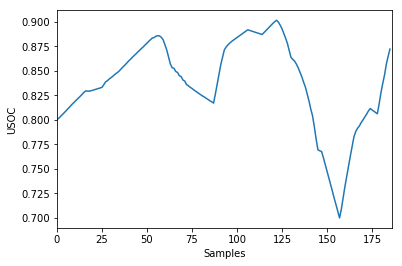

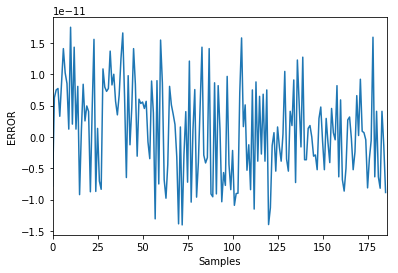

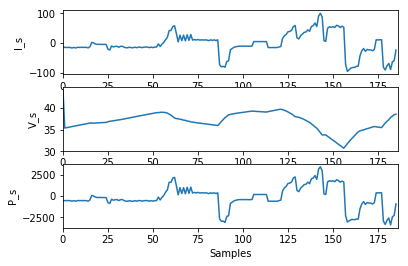

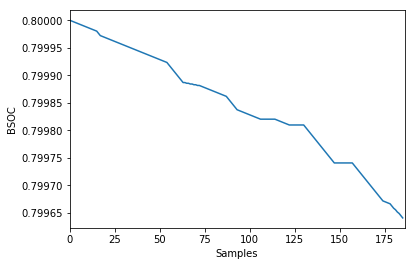

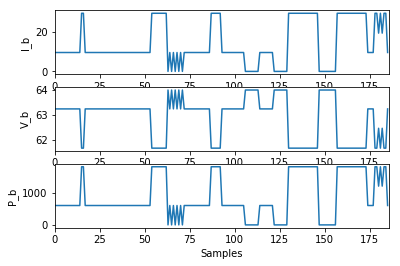

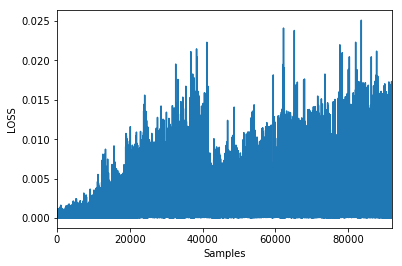

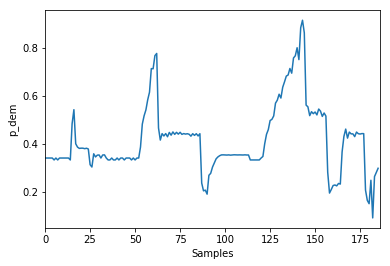

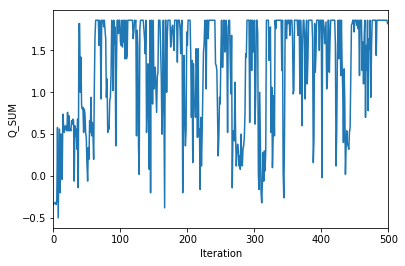

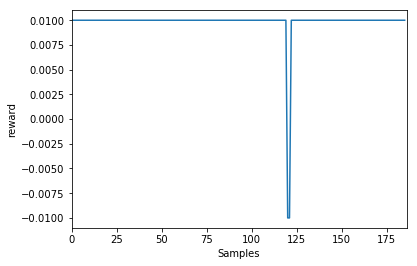

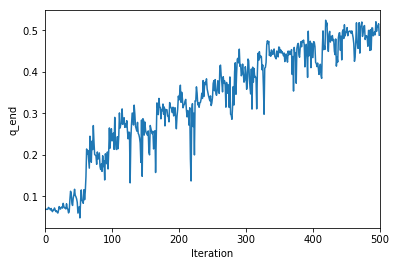

In [13]:
import tensorflow as tf
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
from pandas import read_csv


tf.reset_default_graph()
tf.set_random_seed(1)
np.random.seed(1)

# import training data
# ECE_T = np.genfromtxt('../data/ECE_T.txt', skip_header=1, delimiter=' ', dtype=None)
# ECE_S = np.genfromtxt('../data/ECE_S.txt', skip_header=1, delimiter=' ', dtype=None)
# ECE_P=ECE_T*ECE_S/9.549
ECE_P=np.genfromtxt('../data/ECE_P.txt', skip_header=1, delimiter=' ', dtype=None)*1000

# EUDC_T = np.genfromtxt('../data/EUDC_T.txt', skip_header=1, delimiter=' ', dtype=None)
# EUDC_S = np.genfromtxt('../data/EUDC_S.txt', skip_header=1, delimiter=' ', dtype=None)
# EUDC_P=EUDC_T*EUDC_S/9.549
EUDC_P=np.genfromtxt('../data/EUDC_P部分.txt', skip_header=1, delimiter=' ', dtype=None)*1000

HWFET_T = np.genfromtxt('../data/HWFET_T.txt', skip_header=1, delimiter=' ', dtype=None)
HWFET_S = np.genfromtxt('../data/HWFET_S.txt', skip_header=1, delimiter=' ', dtype=None)
HWFET_P=HWFET_T*HWFET_S/9.549
# print(HWFET_P.shape)=7659

# data=sio.loadmat('trainpower2.mat')
# data=read_csv(open('UDDS.csv'),engine='python')
# one-dimension numpy array
# data1=data.values.flatten()
# 采样精度0.1s，按每10位取平均数
# data2=np.mean(EUDC_P[:int(np.size(EUDC_P)/10)*10].reshape(-1,10),axis=1)
# data2=data2[:685]
# 归一化
## ECE
Max=6000
Min=-3000
# EUDC
# Max=EUDC_P.max()
# Min=EUDC_P.min()
p_dem=(ECE_P-Min)/(Max-Min)


# # hyper parameters of HWFET
# M=100                      #maximum iteration
# EPSILON=0.9             #greedy factor
# GAMMA=0.99               #discount factor
# N_HIDDEN=30             #number of hidden neuron
# N_STATES=2              #number of states
# N_ACTIONS=21            #number of output neuron/action
# D=300                   #dispersion of action space
# BATCH=100               #training batch
# LR=0.001                #learning rate
# DELTA_T=1               #sampling time step
# C=200                   #every C step update target net
# POOL_SIZE=3000          #size of experience pool
## reward-=-0.01

# hyper parameters of ECE
M=500                     #maximum iteration
EPSILON=0.9             #greedy factor
GAMMA=0.99               #discount factor
N_HIDDEN=15             #number of hidden neuron
N_STATES=2              #number of states
N_ACTIONS=7            #number of output neuron/action
D=300                   #dispersion of action space
BATCH=30               #training batch
LR=0.001                #learning rate
DELTA_T=1               #sampling time step
C=1000                   #every C step update target net
POOL_SIZE=1000          #size of experience pool
# reward-=-0.01,i>M-100,i_s>180,p_dem:EUDC->ECE,Max,Min,save


# # hyper parameters of EUDC
# M=500                     #maximum iteration
# EPSILON=0.9             #greedy factor
# GAMMA=0.9               #discount factor
# N_HIDDEN=15             #number of hidden neuron
# N_STATES=2              #number of states
# N_ACTIONS=21            #number of output neuron/action
# D=300                   #dispersion of action space
# BATCH=150               #training batch
# LR=0.001                #learning rate
# DELTA_T=1               #sampling time step
# C=1000                   #every C step update target net
# POOL_SIZE=5000          #size of experience pool
# # reward-=-0.03,i>M-20,p_dem:ECE->EUDC,Max,Min,save


# initialization
U_b=64        #open-loop voltage of li-battery
U_max=44        #maximum voltage of super-capacitor
U_s=44        #ideal voltage of super-capacitor
R_b=0.08      #internal resistance of li-battery
R_s=0.0063    #internal resistance of super-capacitor
Q_b=2000      #battery capacity
Q_s=8019      #capacitor capacity

LOSS=[]
Q_SUM=[]
Q_END=[]
LEARNING_COUNTER=0      #for target net updating
COUNTER=0               # for experience updating   
T=p_dem.size            #episode length
POOL=np.zeros((POOL_SIZE,N_STATES*2+2)) 

# define graph
tf_s=tf.placeholder(tf.float32,[None,N_STATES],name='tf_s')
tf_a=tf.placeholder(tf.int32,[None,],name='tf_a')
tf_r=tf.placeholder(tf.float32,[None,],name='tf_r')
tf_s_=tf.placeholder(tf.float32,[None,N_STATES],name='tf_s_')

with tf.variable_scope('train_net'):
    h=tf.layers.dense(tf_s,N_HIDDEN,tf.nn.relu,kernel_initializer=tf.random_normal_initializer(0,0.1))
    q=tf.layers.dense(h,N_ACTIONS,kernel_initializer=tf.random_normal_initializer(0,0.1))
    
with tf.variable_scope('target_net'):
    h_=tf.layers.dense(tf_s_,N_HIDDEN,tf.nn.relu,trainable=False)
    q_=tf.layers.dense(h_,N_ACTIONS,trainable=False)

#s_end=[-1,-1]对应的q_需要置0
q_target=tf_r+GAMMA*tf.multiply(tf.reduce_max(q_,axis=1),tf.cast(tf.cast(tf_s_[:,1]+1,bool),tf.float32))
q_wrt_a=tf.reduce_max(tf.multiply(tf.one_hot(tf_a,N_ACTIONS),q),axis=1)
# a_indices = tf.stack([tf.range(tf.shape(tf_a)[0], dtype=tf.int32), tf_a], axis=1)
# q_wrt_a = tf.gather_nd(params=q, indices=a_indices)     # shape=[None, ],[None,1]!=[None,]

loss = tf.reduce_mean(tf.squared_difference(q_target, q_wrt_a))
train_op = tf.train.AdamOptimizer(LR).minimize(loss)

t_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='target_net')
e_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='train_net')
update=[tf.assign(t, e) for t, e in zip(t_params, e_params)]


tf.summary.scalar('W1_mean',tf.reduce_mean(e_params[0]))
tf.summary.scalar('W1_max',tf.reduce_max(e_params[0]))
tf.summary.scalar('W1_min',tf.reduce_min(e_params[0]))
tf.summary.scalar('W1_var',tf.reduce_mean(tf.square(e_params[0]-tf.reduce_mean(e_params[0]))))
tf.summary.scalar('b1_mean',tf.reduce_mean(e_params[1]))
tf.summary.scalar('b1_max',tf.reduce_max(e_params[1]))
tf.summary.scalar('b1_min',tf.reduce_min(e_params[1]))
tf.summary.scalar('b1_var',tf.reduce_mean(tf.square(e_params[1]-tf.reduce_mean(e_params[1]))))
tf.summary.scalar('W2_mean',tf.reduce_mean(e_params[2]))
tf.summary.scalar('W2_max',tf.reduce_max(e_params[2]))
tf.summary.scalar('W2_min',tf.reduce_min(e_params[2]))
tf.summary.scalar('W2_var',tf.reduce_mean(tf.square(e_params[2]-tf.reduce_mean(e_params[2]))))
tf.summary.scalar('b2_mean',tf.reduce_mean(e_params[3]))
tf.summary.scalar('b2_max',tf.reduce_max(e_params[3]))
tf.summary.scalar('b2_min',tf.reduce_min(e_params[3]))
tf.summary.scalar('b2_var',tf.reduce_mean(tf.square(e_params[3]-tf.reduce_mean(e_params[3]))))
tf.summary.histogram('h',h)
tf.summary.histogram('q',q)
tf.summary.histogram('W1',e_params[0])
tf.summary.histogram('b1',e_params[1])
tf.summary.histogram('W2',e_params[2])
tf.summary.histogram('b2',e_params[3])
writer = tf.summary.FileWriter("/Users/xieliang/tensorboard/log")
summaries = tf.summary.merge_all()

sess=tf.Session()
sess.run(tf.global_variables_initializer())
    

def choose_action(s):
    
    s=s[np.newaxis,:]
    
    if np.random.uniform()<=EPSILON:
        q_value=sess.run(q,feed_dict={tf_s:s})
        action_index=np.argmax(q_value)
        Q_max.append(np.max(q_value))
    else:
        action_index=np.random.randint(0,N_ACTIONS)
        
    return action_index


def env(action_index,t):
    
    global usoc,USOC,U_s,bsoc,BSOC,I_s,V_s,P_s,I_b,V_b,P_b,ERROR,REWARD
    
    # power allocation for battery
    p_b=action_index*D
    
    #battery soc update
    i_b=(U_b-(U_b**2-4*p_b*R_b)**0.5)/(2*R_b)
    i_b=100 if i_b>100 else i_b
    u_b=U_b-i_b*R_b
    p_b=i_b*u_b
    BSOC.append(bsoc)
    bsoc=bsoc-i_b*DELTA_T/(3600*Q_b)
    
    #power allocation for capacitor
    p_s=p_dem[t]*(Max-Min)+Min-p_b
    
    #capacitor soc update
    p_s=0 if (usoc>0.95 and p_s<=0) or (usoc<0.4 and p_s>0) else p_s
    i_s=(U_s-(U_s**2-4*p_s*R_s)**0.5)/(2*R_s)
    i_s=180 if i_s>180 else i_s
    i_s=-180 if i_s<-180 else i_s
    u_s=U_s-i_s*R_s
    p_s=u_s*i_s
    USOC.append(usoc)
    usoc=usoc-i_s*DELTA_T/Q_s
    U_s=usoc*U_max
    
    
    #s_end=[-1,-1]
    s_=np.array([-1,-1]) if t==T-1 else np.array([p_dem[t+1],usoc])
    error=p_dem[t]*(Max-Min)+Min-p_b-p_s
    reward=-0.01 if (usoc<0.45 or usoc>0.9) else 0.01
    
    #for figure analysis
    I_s.append(i_s)
    V_s.append(u_s)
    P_s.append(p_s)
    I_b.append(i_b)
    V_b.append(u_b)
    P_b.append(p_b)
    ERROR.append(error)
    REWARD.append(reward)
    return [reward,s_]
    
    
def store_trasition(s,a,r,s_):
    global COUNTER,POOL
    transition=np.hstack((s,[a,r],s_))
    index=COUNTER%POOL_SIZE
#     POOL不需要声明为全局变量？
    POOL[index,:]=transition
    COUNTER+=1
    
def learn():
    #update the target net
    global LEARNING_COUNTER,weights
    if LEARNING_COUNTER%C==0:
        sess.run(update)
    LEARNING_COUNTER+=1
    
    #train the train net
    batch_indices=np.random.choice(POOL_SIZE,BATCH)
    batch=POOL[batch_indices,:]
    b_s=batch[:,:N_STATES]
    b_a=batch[:,N_STATES].astype(int)
    b_r=batch[:,N_STATES+1]
    b_s_=batch[:,-N_STATES:]
    weights,loss_,_=sess.run([e_params,loss,train_op],feed_dict={tf_s:b_s,tf_a:b_a,tf_r:b_r,tf_s_:b_s_})
    LOSS.append(loss_)
#     summ,loss_,_=sess.run([summaries,loss,train_op],feed_dict={tf_s:b_s,tf_a:b_a,tf_r:b_r,tf_s_:b_s_})
#     writer.add_summary(summ,COUNTER)
    

for i in range(M):
    
    #initial state
    bsoc=0.8      
    usoc=0.8  
    U_s=U_max
    s=np.array([p_dem[0],usoc])
    # for figure analysis
    USOC=[]
    BSOC=[]
    I_s=[]
    V_s=[]
    P_s=[]
    I_b=[]
    V_b=[]
    P_b=[]
    ERROR=[]
    REWARD=[]
    Q_max=[]
    print(i,end=' ')
    
    if i>M-100:
        EPSILON=1.0
    
    for t in range(T):
        
        a=choose_action(s)
        r,s_=env(a,t)
        store_trasition(s,a,r,s_)
        
        if COUNTER>=POOL_SIZE:
            learn()
         
        s=s_
        
    Q_SUM.append(sum(REWARD))
    Q_END.append(Q_max[-1])
    
Q_END=np.array(Q_END).flatten()
# sio.savemat('Wb_ECE.mat',{'Wb_ECE':weights})
        

%matplotlib inline
# %matplotlib notebook
plt.figure(1)
plt.plot(range(len(USOC)),USOC)
plt.xlabel('Samples')
plt.ylabel('USOC')
plt.xlim(0,len(USOC))
plt.figure(2)
plt.plot(range(len(ERROR)),ERROR)
plt.xlabel('Samples')
plt.ylabel('ERROR')
plt.xlim(0,len(ERROR))
plt.figure(3)
ax1=plt.subplot(311)
plt.plot(range(len(I_s)),I_s)
plt.xlabel('Samples')
plt.ylabel('I_s')
plt.xlim(0,len(I_s))
ax2=plt.subplot(312)
plt.plot(range(len(V_s)),V_s)
plt.xlabel('Samples')
plt.ylabel('V_s')
plt.xlim(0,len(V_s))
ax3=plt.subplot(313)
plt.plot(range(len(P_s)),P_s)
plt.xlabel('Samples')
plt.ylabel('P_s')
plt.xlim(0,len(P_s))
plt.figure(4)
plt.plot(range(len(BSOC)),BSOC)
plt.xlabel('Samples')
plt.ylabel('BSOC')
plt.xlim(0,len(BSOC))
plt.figure(5)
ax1=plt.subplot(311)
plt.plot(range(len(I_b)),I_b)
plt.xlabel('Samples')
plt.ylabel('I_b')
plt.xlim(0,len(I_b))
ax2=plt.subplot(312)
plt.plot(range(len(V_b)),V_b)
plt.xlabel('Samples')
plt.ylabel('V_b')
plt.xlim(0,len(V_b))
ax3=plt.subplot(313)
plt.plot(range(len(P_b)),P_b)
plt.xlabel('Samples')
plt.ylabel('P_b')
plt.xlim(0,len(P_b))
plt.figure(6)
plt.plot(range(len(LOSS)),LOSS)
plt.xlabel('Samples')
plt.ylabel('LOSS')
plt.xlim(0,len(LOSS))
plt.figure(7)
plt.plot(range(len(p_dem)),p_dem)
plt.xlabel('Samples')
plt.ylabel('p_dem')
plt.xlim(0,len(p_dem)) 
plt.figure(8)
plt.plot(range(len(Q_SUM)),Q_SUM)
plt.xlabel('Iteration')
plt.ylabel('Q_SUM')
plt.xlim(0,len(Q_SUM))
plt.figure(9)
plt.plot(range(len(REWARD)),REWARD)
plt.xlabel('Samples')
plt.ylabel('reward')
plt.xlim(0,len(REWARD))
plt.figure(10)
plt.plot(range(len(Q_END)),Q_END)
plt.xlabel('Iteration')
plt.ylabel('q_end')
plt.xlim(0,len(Q_END))
plt.show()

# tf.gfile.DeleteRecursively("/Users/xieliang/tensorboard/log") 
# summary_writer = tf.summary.FileWriter("/Users/xieliang/tensorboard/log", sess.graph)   


## NOTE: 
#tensorflow:
# 根据下标批量获取数组元素，1）tf.one_hot; 2) tf.gather_nd; 3) numpy,a[(index_array),(index_array)]
# 不要在需要迭代的函数中定义operation/改变graph，会增加时间成本
# DQN:
# reward设计不合理(太大)会导致loss不收敛
# 状态需归一化，否则容易导致太小的那一维的信息被忽略。p_dem的维度应归一到和soc一致
# s和s_应有较大的区别，否则reward直接变成ground truth，所有神经元的表现趋于一致
# reward和q应该在同一个数量级上，否则reward直接变成ground truth，q表现趋于一致
# 随着训练神经网络的权值和阈值的方差应该变大
#调试：
#模型结构->样本->超参数

In [12]:
# Torque=np.mean(EUDC_T[:int(np.size(EUDC_T)/10)*10].reshape(-1,10),axis=1)
# Torque_=Torque[:685]
# Speed=np.mean(EUDC_S[:int(np.size(EUDC_S)/10)*10].reshape(-1,10),axis=1)
# Speed_=Speed[:685]

# # x=np.array([1,2,3])
# np.savetxt('EUDC_T',Torque_)
# np.savetxt('EUDC_S',Speed_)
print(Max)
print(Min)

5094.400000000001
-1625.3


In [51]:
print(data1.size)
# qq=data1
# # qq=(qq-qq.min())/(qq.max()-qq.min())
# qq=np.mean(qq.reshape(-1,10),axis=1)
# print(qq[0:30])

# i_s=0
# i_s=200 if i_s>200 else i_s
# i_s=40 if (i_s>0 and i_s<40) else i_s
# i_s=-200 if i_s<-200 else i_s
# i_s=-40 if (i_s>-40 and i_s<0) else i_s
# print(i_s)

13690


In [ ]:
"""
Know more, visit my Python tutorial page: https://morvanzhou.github.io/tutorials/
My Youtube Channel: https://www.youtube.com/user/MorvanZhou
More about Reinforcement learning: https://morvanzhou.github.io/tutorials/machine-learning/reinforcement-learning/
Dependencies:
tensorflow: 1.1.0
matplotlib
numpy
gym: 0.8.1
"""
import tensorflow as tf
import numpy as np
import gym

tf.set_random_seed(1)
np.random.seed(1)

# Hyper Parameters
BATCH_SIZE = 32
LR = 0.01                   # learning rate
EPSILON = 0.9               # greedy policy
GAMMA = 0.9                 # reward discount
TARGET_REPLACE_ITER = 100   # target update frequency
MEMORY_CAPACITY = 2000
MEMORY_COUNTER = 0          # for store experience
LEARNING_STEP_COUNTER = 0   # for target updating
env = gym.make('CartPole-v0')
env = env.unwrapped
N_ACTIONS = env.action_space.n
N_STATES = env.observation_space.shape[0]
MEMORY = np.zeros((MEMORY_CAPACITY, N_STATES * 2 + 2))     # initialize memory

# tf placeholders
tf_s = tf.placeholder(tf.float32, [None, N_STATES])
tf_a = tf.placeholder(tf.int32, [None, ])
tf_r = tf.placeholder(tf.float32, [None, ])
tf_s_ = tf.placeholder(tf.float32, [None, N_STATES])

with tf.variable_scope('q'):        # evaluation network
    l_eval = tf.layers.dense(tf_s, 10, tf.nn.relu, kernel_initializer=tf.random_normal_initializer(0, 0.1))
    q = tf.layers.dense(l_eval, N_ACTIONS, kernel_initializer=tf.random_normal_initializer(0, 0.1))

with tf.variable_scope('q_next'):   # target network, not to train
    l_target = tf.layers.dense(tf_s_, 10, tf.nn.relu, trainable=False)
    q_next = tf.layers.dense(l_target, N_ACTIONS, trainable=False)

q_target = tf_r + GAMMA * tf.reduce_max(q_next, axis=1)                   # shape=(None, ),

a_indices = tf.stack([tf.range(tf.shape(tf_a)[0], dtype=tf.int32), tf_a], axis=1)
q_wrt_a = tf.gather_nd(params=q, indices=a_indices)     # shape=(None, ), q for current state

loss = tf.reduce_mean(tf.squared_difference(q_target, q_wrt_a))
train_op = tf.train.AdamOptimizer(LR).minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())


def choose_action(s):
    s = s[np.newaxis, :]
    if np.random.uniform() < EPSILON:
        # forward feed the observation and get q value for every actions
        actions_value = sess.run(q, feed_dict={tf_s: s})
        action = np.argmax(actions_value)
    else:
        action = np.random.randint(0, N_ACTIONS)
    return action


def store_transition(s, a, r, s_):
    global MEMORY_COUNTER
    transition = np.hstack((s, [a, r], s_))
    # replace the old memory with new memory
    index = MEMORY_COUNTER % MEMORY_CAPACITY
    MEMORY[index, :] = transition
    MEMORY_COUNTER += 1


def learn():
    # update target net
    global LEARNING_STEP_COUNTER
    if LEARNING_STEP_COUNTER % TARGET_REPLACE_ITER == 0:
        t_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='q_next')
        e_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='q')
        sess.run([tf.assign(t, e) for t, e in zip(t_params, e_params)])
    LEARNING_STEP_COUNTER += 1

    # learning
    sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
    b_memory = MEMORY[sample_index, :]
    b_s = b_memory[:, :N_STATES]
    b_a = b_memory[:, N_STATES].astype(int)
    b_r = b_memory[:, N_STATES+1]
    b_s_ = b_memory[:, -N_STATES:]
    sess.run(train_op, {tf_s: b_s, tf_a: b_a, tf_r: b_r, tf_s_: b_s_})

print('\nCollecting experience...')
for i_episode in range(400):
    s = env.reset()
    ep_r = 0
    while True:
        env.render()
        a = choose_action(s)

        # take action
        s_, r, done, info = env.step(a)

        # modify the reward
        x, x_dot, theta, theta_dot = s_
        r1 = (env.x_threshold - abs(x)) / env.x_threshold - 0.8
        r2 = (env.theta_threshold_radians - abs(theta)) / env.theta_threshold_radians - 0.5
        r = r1 + r2

        store_transition(s, a, r, s_)

        ep_r += r
        if MEMORY_COUNTER > MEMORY_CAPACITY:
            learn()
            if done:
                print('Ep: ', i_episode,
                      '| Ep_r: ', round(ep_r, 2))

        if done:
            break
        s = s_

# test

In [9]:
print(int(np.size(np.array([1,2,3]))/2))

1


In [36]:
import tensorflow as tf

tf.reset_default_graph()
tf.set_random_seed(1)
np.random.seed(1)

# Hyper Parameters
BATCH_SIZE = 32
LR = 0.01                   # learning rate
EPSILON = 0.9               # greedy policy
GAMMA = 0.9                 # reward discount
TARGET_REPLACE_ITER = 100   # target update frequency
MEMORY_CAPACITY = 2000
MEMORY_COUNTER = 0          # for store experience
LEARNING_STEP_COUNTER = 0   # for target updating
N_ACTIONS = 10
N_STATES = 20
MEMORY = np.zeros((MEMORY_CAPACITY, N_STATES * 2 + 2))     # initialize memory

# tf placeholders
tf_s = tf.placeholder(tf.float32, [None, N_STATES])
tf_a = tf.placeholder(tf.int32, [None, ])
tf_r = tf.placeholder(tf.float32, [None, ])
tf_s_ = tf.placeholder(tf.float32, [None, N_STATES])

with tf.variable_scope('q'):        # evaluation network
    l_eval = tf.layers.dense(tf_s, 10, tf.nn.relu, kernel_initializer=tf.random_normal_initializer(0, 0.1))
    q = tf.layers.dense(l_eval, N_ACTIONS, kernel_initializer=tf.random_normal_initializer(0, 0.1))

with tf.variable_scope('q_next'):   # target network, not to train
    l_target = tf.layers.dense(tf_s_, 10, tf.nn.relu, trainable=False)
    q_next = tf.layers.dense(l_target, N_ACTIONS, trainable=False)

q_target = tf_r + GAMMA * tf.reduce_max(q_next, axis=1)                   # shape=(None, ),

a_indices = tf.stack([tf.range(tf.shape(tf_a)[0], dtype=tf.int32), tf_a], axis=1)
q_wrt_a = tf.gather_nd(params=q, indices=a_indices)     # shape=(None, ), q for current state

loss = tf.reduce_mean(tf.squared_difference(q_target, q_wrt_a))
train_op = tf.train.AdamOptimizer(LR).minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
summary_writer = tf.summary.FileWriter("/Users/xieliang/tensorboard/log", sess.graph)

In [32]:
import tensorflow as tf

tf.reset_default_graph()
tf.set_random_seed(1)
np.random.seed(1)

# Hyper Parameters
BATCH_SIZE = 32
LR = 0.01                   # learning rate
EPSILON = 0.9               # greedy policy
GAMMA = 0.9                 # reward discount
TARGET_REPLACE_ITER = 100   # target update frequency
MEMORY_CAPACITY = 2000
MEMORY_COUNTER = 0          # for store experience
LEARNING_STEP_COUNTER = 0   # for target updating
N_ACTIONS = 10
N_STATES = 20
MEMORY = np.zeros((MEMORY_CAPACITY, N_STATES * 2 + 2))     # initialize memory


def graph(tf_s,tf_a,tf_r,tf_s_):
    with tf.variable_scope('q'):        # evaluation network
        l_eval = tf.layers.dense(tf_s, 10, tf.nn.relu, kernel_initializer=tf.random_normal_initializer(0, 0.1))
        q = tf.layers.dense(l_eval, N_ACTIONS, kernel_initializer=tf.random_normal_initializer(0, 0.1))

    with tf.variable_scope('q_next'):   # target network, not to train
        l_target = tf.layers.dense(tf_s_, 10, tf.nn.relu, trainable=False)
        q_next = tf.layers.dense(l_target, N_ACTIONS, trainable=False)

    q_target = tf_r + GAMMA * tf.reduce_max(q_next, axis=1)                   # shape=(None, ),

    a_indices = tf.stack([tf.range(tf.shape(tf_a)[0], dtype=tf.int32), tf_a], axis=1)
    q_wrt_a = tf.gather_nd(params=q, indices=a_indices)     # shape=(None, ), q for current state

    loss = tf.reduce_mean(tf.squared_difference(q_target, q_wrt_a))
    train_op = tf.train.AdamOptimizer(LR).minimize(loss)
    return train_op

# tf placeholders
tf_s = tf.placeholder(tf.float32, [None, N_STATES])
tf_a = tf.placeholder(tf.int32, [None, ])
tf_r = tf.placeholder(tf.float32, [None, ])
tf_s_ = tf.placeholder(tf.float32, [None, N_STATES])
train_op=graph(tf_s,tf_a,tf_r,tf_s_)
    
sess = tf.Session()
sess.run(tf.global_variables_initializer())
summary_writer = tf.summary.FileWriter("/Users/xieliang/tensorboard/log", sess.graph)

In [20]:
import numpy as np

# np.random.seed(1)
# for i in range(10):
#     print(np.random.uniform())

a=np.array([[1],[2],[32],[6]])
print(a)


[[ 1]
 [ 2]
 [32]
 [ 6]]


In [7]:
import tensorflow as tf
import numpy as np

tf.reset_default_graph()
a=tf.Variable([[1.0,2.0],[2.0,3.0],[4.0,5.0]]) 
b=tf.Variable([[4.0,5.0,6.0],[1.0,2.0,3.0],[3.0,4.0,2.0],[4,2,8]])
c=tf.reduce_max(a,reduction_indices=1)
m=tf.reduce_max(b,reduction_indices=1)
g=tf.constant([0,1,3,0])
f=tf.one_hot(g,3)
h=tf.multiply(f,b)
i=tf.reduce_max(h,reduction_indices=1)
j=tf.constant([1,-1,3,-1,2,9])
k=tf.Variable([2,3,4,5,6,7])
n=tf.cast(tf.cast(j+1,bool),tf.int32)
o=tf.multiply(n,k)
i=tf.reduce_sum(tf.square(o))
l=tf.reduce_max(g)
x=tf.placeholder(tf.float32,[None,1])
y=tf.shape(x)
p=tf.reshape(b,shape=[-1,])
q=tf.reduce_mean(b)
r=tf.reduce_mean(tf.square(b-q))

sess=tf.Session()
sess.run(tf.global_variables_initializer())
# print(sess.run(c)) 
# print(sess.run(m))
# print(sess.run(g))
# print(sess.run(f))
# print(sess.run(h))
# print(sess.run(i))
# print(sess.run(n))
# print(sess.run(o))
# print(sess.run(i))
# print(sess.run(y,feed_dict={x:[[1],[2],[3]]}))
print(sess.run(r))

3.5555553


In [61]:
import tensorflow as tf

tf.reset_default_graph()
g2=tf.Graph()
sess=tf.Session()
sess2=tf.Session(graph=g2)

def build_graph():
    d=tf.Variable([10])
    return d

def graph2(x):
    return x

with tf.variable_scope("test",reuse=tf.AUTO_REUSE) as scope:
    a=build_graph()

with g2.as_default():
    x_=tf.placeholder("float",shape=[1])
    c=graph2(x_)



sess.run(tf.global_variables_initializer())
print(sess.run(a))
print(sess2.run(c,feed_dict={x_:sess.run(a)}))

summary_writer = tf.summary.FileWriter("/Users/xieliang/tensorboard/log", sess.graph)

[10]
[10.]


In [11]:
import random
n=80
n=50 if n<20 or n>50 else n



# epsilon=random.randint(0,100)/100
# print(epsilon)

# a=4
# b=a**2
# print(b)
# print(100*random.random())
# print(2e+3)

# x=10
# y=20
# if (x>=10 and x<109) or (y<20 and y>30):
#     print('y')
# else:
#     print('x')

ValueError: empty range for randrange() (0,0, 0)

In [233]:
for i in range(10):
    if i==9:
        print(i)

9


4611
19


<IPython.core.display.Javascript object>


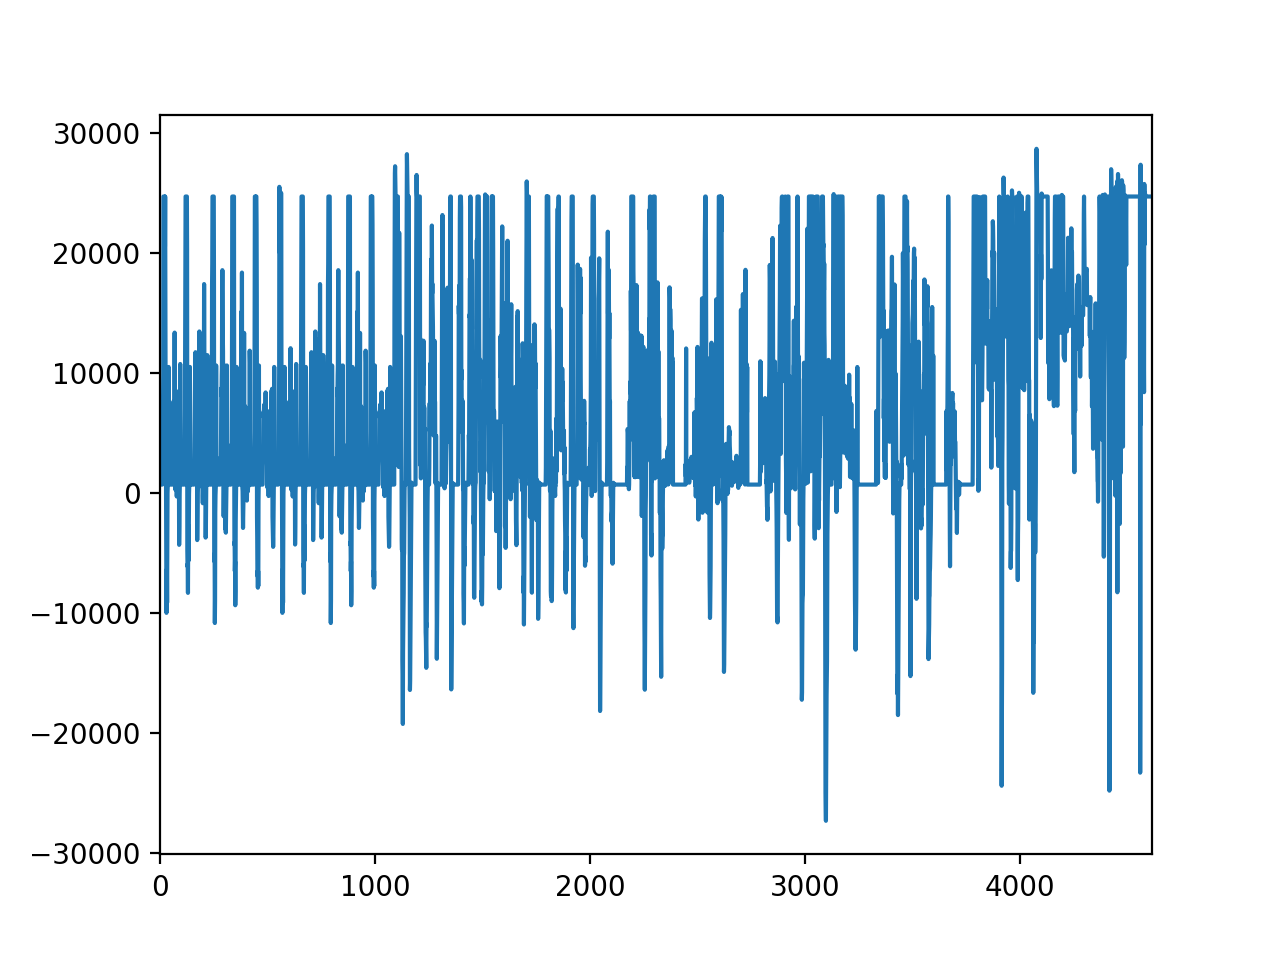

<IPython.core.display.Javascript object>


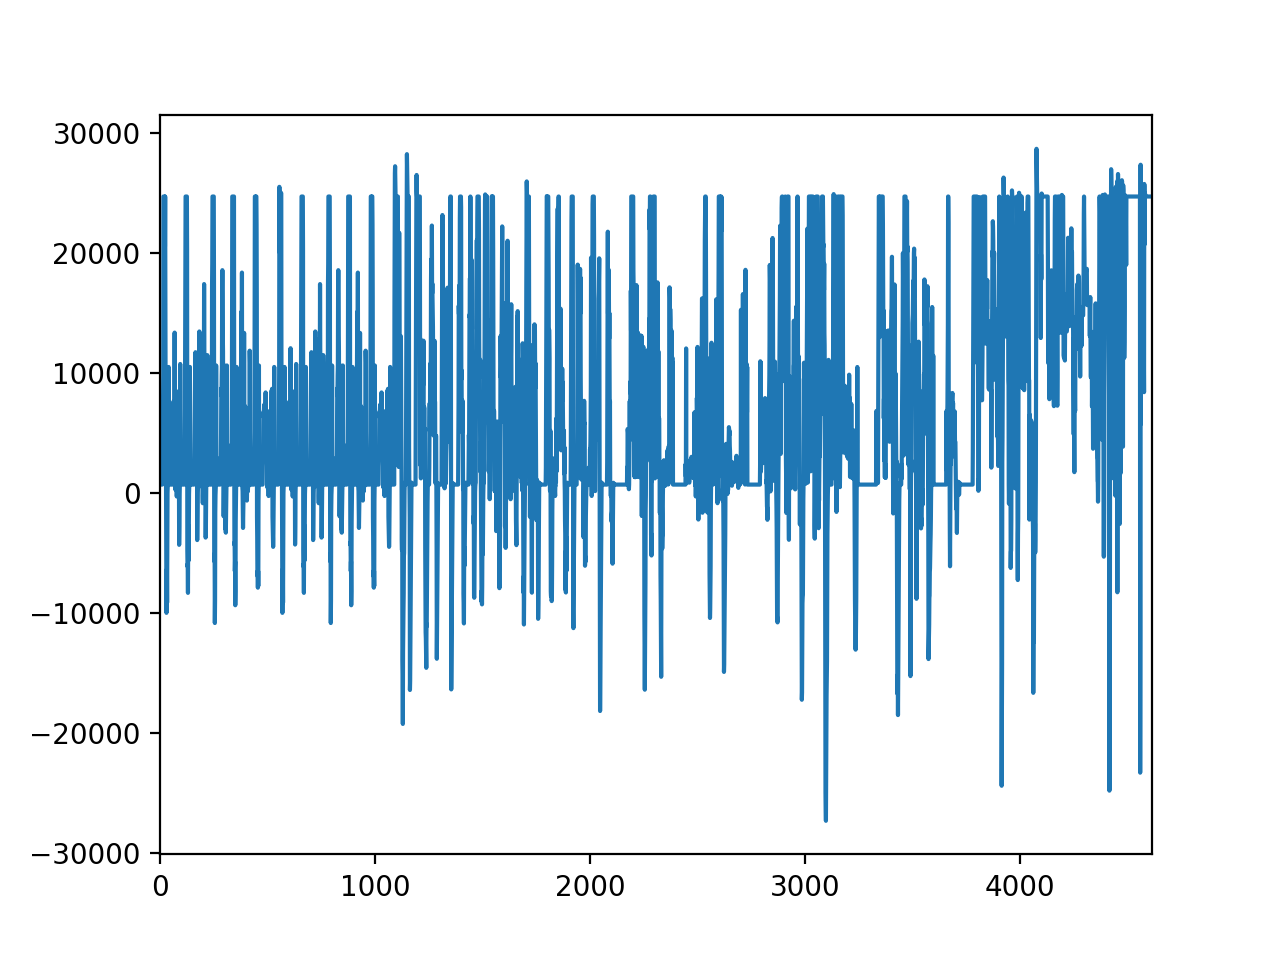

<IPython.core.display.Javascript object>


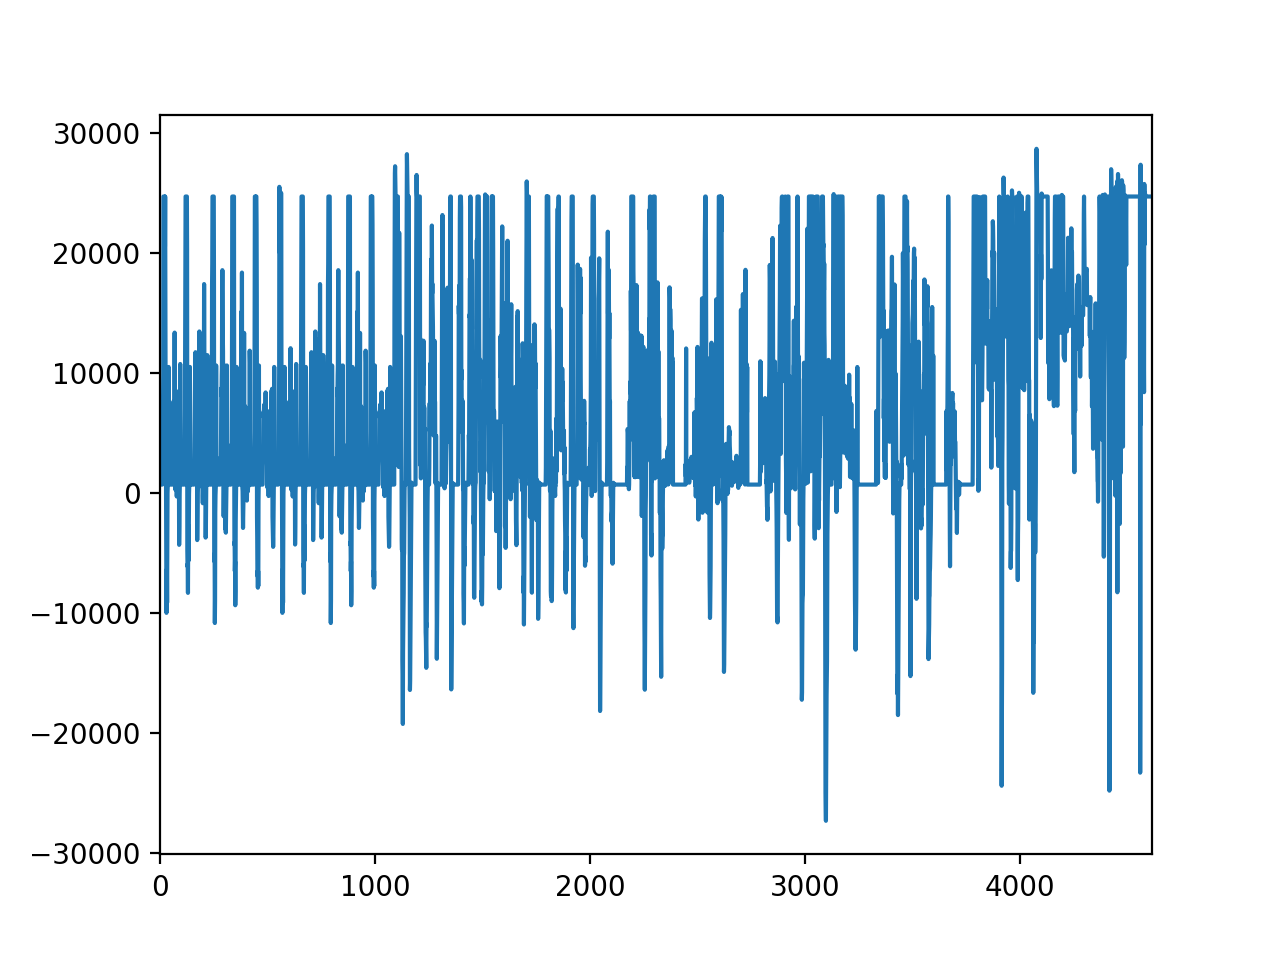

In [117]:
import scipy.io as sio 
import matplotlib.pyplot as plt

%matplotlib notebook
data=sio.loadmat('trainpower2.mat') 
xx=data['trainpower'][:,0]
print(len(xx)-1)
y=list(xx)
y.append(19)
print(y[4612])
for i in range(3):
    plt.figure(i)
    plt.plot(range(len(xx)),xx)
    plt.xlim(0,4612)
    plt.show()

In [185]:
import numpy as np
s=[1,2]
s_=[np.newaxis,s]
print(s_)

[None, [1, 2]]


In [57]:
a=[1,2,3,4]
b=[5,6,7,8]
zipped=zip(a,b)
print(zipped)
for i,j in zip(a,b):
    print('i:',i,'|j:',j)

i: 1 |j: 5
i: 2 |j: 6
i: 3 |j: 7
i: 4 |j: 8


In [73]:
a=np.array([[1,2],[3,4],[5,6]])
a[[[0],[2]],:]

array([[[1, 2]],

       [[5, 6]]])

In [79]:
s=np.array([1,2])
print(s[np.newaxis,:])

[[1 2]]


In [6]:
def test(i):
    global A
    A.append(i)

A=[]
for i in range(2):
    for j in range(3):
        test(j+i)
print(A)    

[0, 1, 2, 1, 2, 3]


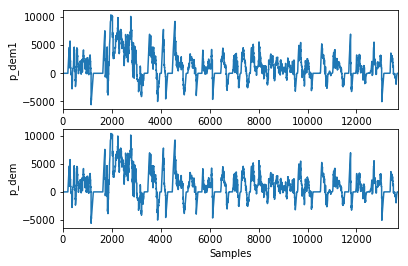

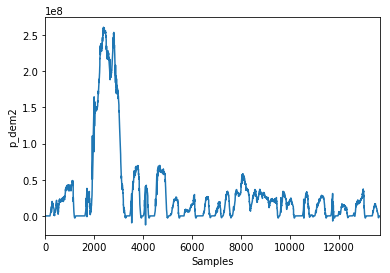

<IPython.core.display.Javascript object>


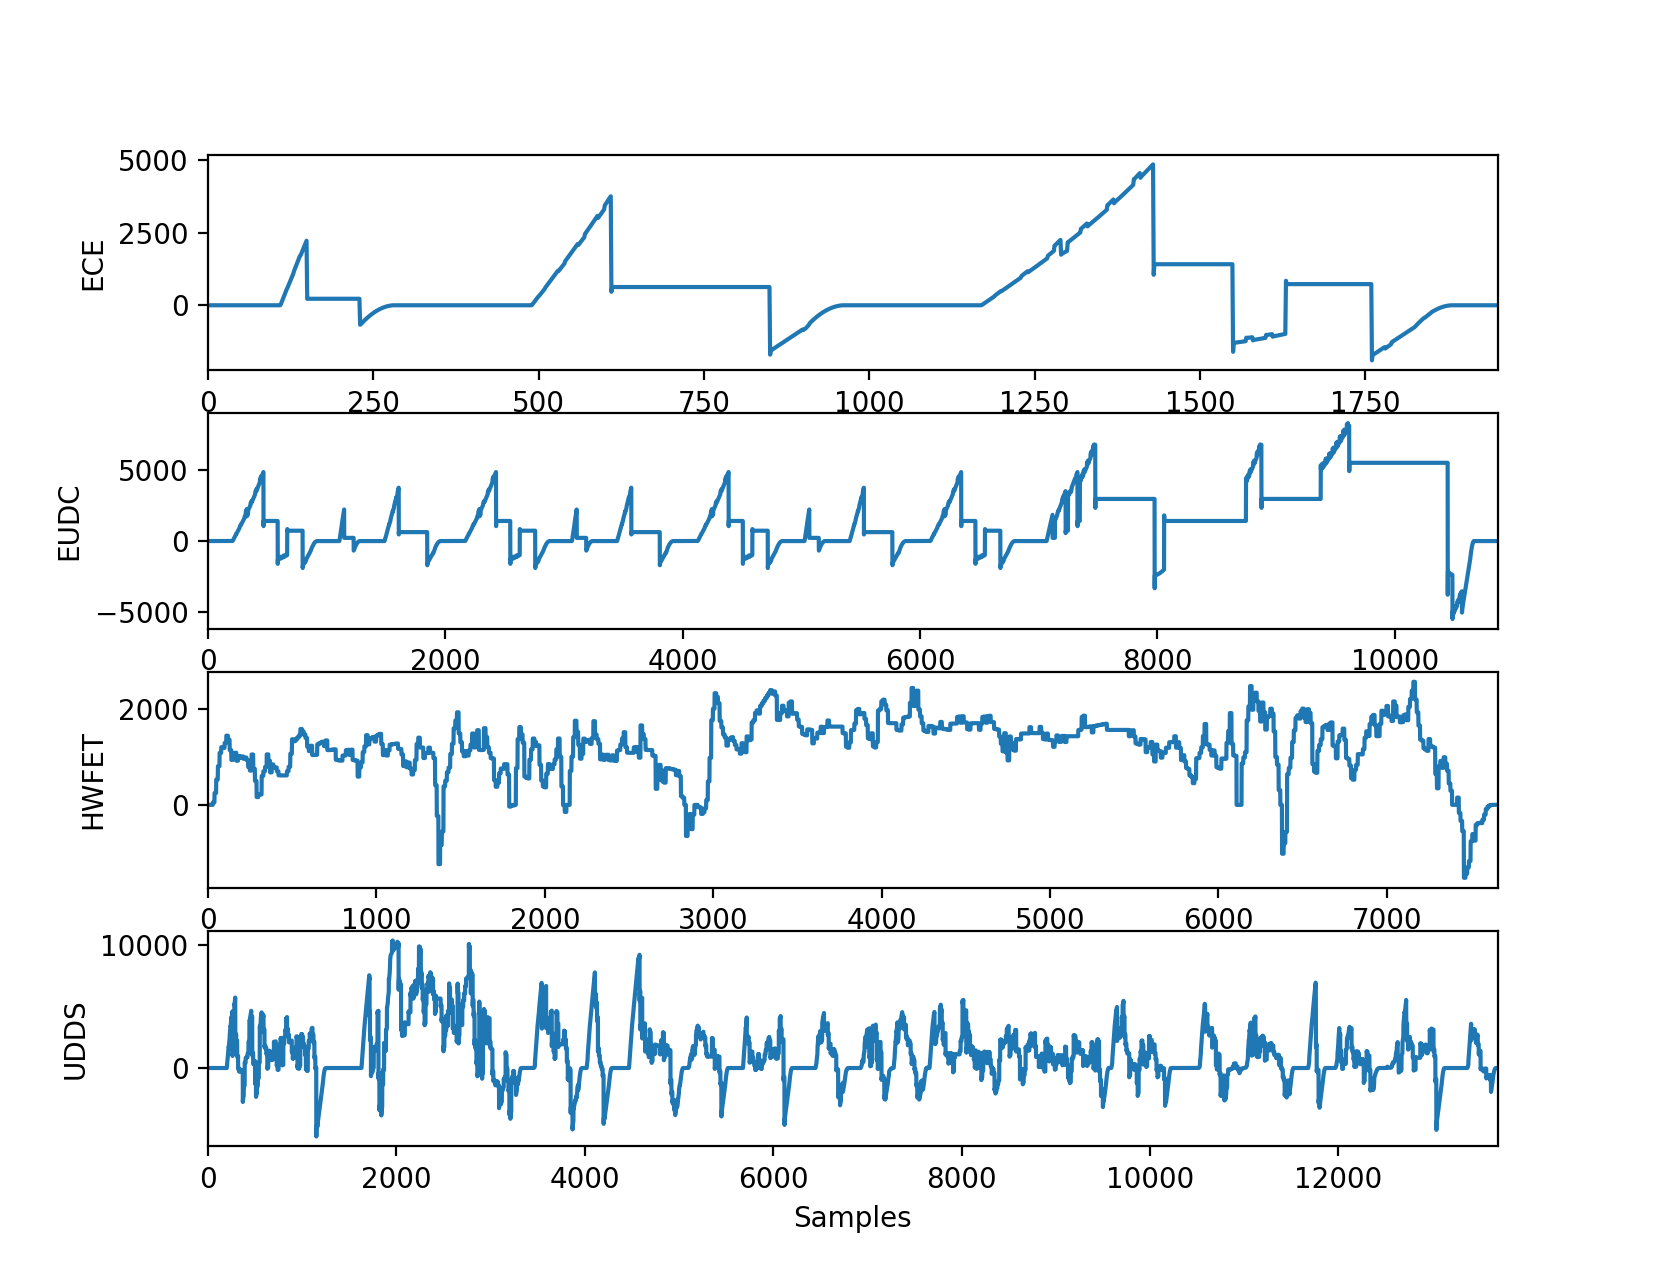

In [3]:
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt


data=read_csv(open('UDDS.csv'),engine='python')
d=data.values.flatten()
Torque=read_csv(open('UDDS_T.csv'),encoding="utf-8",engine='python')
T=Torque.values.flatten()
Speed=read_csv(open('UDDS_S.csv'),engine='python')
S=Speed.values.flatten()

p=T*S/9.549

plt.figure(1)
ax1=plt.subplot(211)
plt.plot(range(len(d)),d)
plt.xlabel('Samples')
plt.ylabel('p_dem1')
plt.xlim(0,len(d))
ax2=plt.subplot(212)
plt.plot(range(len(p)),p)
plt.xlabel('Samples')
plt.ylabel('p_dem')
plt.xlim(0,len(p))
plt.show()


S_1=S[:-1]
S_2=S[1:]
Power=(35.316+0.0214*S_2*S_2+122.2222*(S_2-S_1)*10)*S_2/3.42

plt.figure(2)
plt.plot(range(len(Power)),Power)
plt.xlabel('Samples')
plt.ylabel('p_dem2')
plt.xlim(0,len(Power))
plt.show()

ECE_T = np.genfromtxt('ECE_T.txt', skip_header=1, delimiter=' ', dtype=None)
ECE_S = np.genfromtxt('ECE_S.txt', skip_header=1, delimiter=' ', dtype=None)
ECE_P=ECE_T*ECE_S/9.549

EUDC_T = np.genfromtxt('EUDC_T.txt', skip_header=1, delimiter=' ', dtype=None)
EUDC_S = np.genfromtxt('EUDC_S.txt', skip_header=1, delimiter=' ', dtype=None)
EUDC_P=EUDC_T*EUDC_S/9.549

HWFET_T = np.genfromtxt('HWFET_T.txt', skip_header=1, delimiter=' ', dtype=None)
HWFET_S = np.genfromtxt('HWFET_S.txt', skip_header=1, delimiter=' ', dtype=None)
HWFET_P=HWFET_T*HWFET_S/9.549

UDDS_T = np.genfromtxt('UDDS_T.txt', skip_header=1, delimiter=' ', dtype=None)
UDDS_S = np.genfromtxt('UDDS_S.txt', skip_header=1, delimiter=' ', dtype=None)
UDDS_P=UDDS_T*UDDS_S/9.549

%matplotlib notebook
plt.figure(3)
ax=plt.subplot(411)
plt.plot(range(len(ECE_P)),ECE_P)
plt.xlabel('Samples')
plt.ylabel('ECE')
plt.xlim(0,len(ECE_P))
ax=plt.subplot(412)
plt.plot(range(len(EUDC_P)),EUDC_P)
plt.xlabel('Samples')
plt.ylabel('EUDC')
plt.xlim(0,len(EUDC_P))
ax=plt.subplot(413)
plt.plot(range(len(HWFET_P)),HWFET_P)
plt.xlabel('Samples')
plt.ylabel('HWFET')
plt.xlim(0,len(HWFET_P))
ax=plt.subplot(414)
plt.plot(range(len(UDDS_P)),UDDS_P)
plt.xlabel('Samples')
plt.ylabel('UDDS')
plt.xlim(0,len(UDDS_P))
plt.show()

# print(d[1000:1100])
# print(d.max())
# print(d.min())
# dd=(d-d.min())/(d.max()-d.min())
# print(dd[1000:1100])
# mm=dd*(d.max()-d.min())+d.min()
# print(mm[1000:1100])